# Midterm-Part 2-Classification

In [1]:
from webbot import Browser
from zipfile import ZipFile
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
global scaler
scaler = MinMaxScaler()

from sklearn.metrics import *
from IPython.core.display import HTML
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

import sys
import os
import time
import zipfile
import datetime
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Abhinav\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def navigate(user='tiwari.abhi@husky.neu.edu', password='\nWIB[Lw'):
    global web
    web = Browser()
    web.go_to("https://freddiemac.embs.com/FLoan/secure/login.php?pagename=download2")
    web.type(user, into='email')
    web.type(password, into='password')
    web.click('Submit Credentials')
    web.click('Yes')
    web.click('Continue')

In [3]:
def get_next_quarter_str(quarter_str='Q22005'):
    try:
        quarter_int = int(quarter_str[1:2])
        
        if quarter_int <= 0:
            print('Quarter cannot be lesser than or equal to zero')
            exit(0)
        
        year = int(quarter_str[2:])
        
    except:
        print('Cannot Parse Quarter/Year to Int Value')
        exit(0)
    
    next_quarter = quarter_int + 1
    
    if next_quarter > 4:
        next_quarter = 1
        year = year + 1
    
    next_quarter_str = 'Q'+ str(next_quarter) + str(year)
    return next_quarter_str

In [4]:
def get_both_quarter_data(current_quarter,next_quarter):
    
    quarters = [current_quarter,next_quarter]
    
    global file_names
    file_names = []
    
    for q in quarters:
        web.click('historical_data1_{}.zip'.format(q))
        file_names.append('historical_data1_{}.zip'.format(q))
        time.sleep(20)
    
    global download_path
    download_path = ''
    path_list = os.getcwd().split('\\')[:3]

    for item in path_list:
        download_path = download_path + item + '\\'

    download_path = download_path + 'Downloads'

In [5]:
def assure_path_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
def extract_zipped_files_to_cwd(path_to_downloaded_files):
    global folder_path_all_files
    folder_path_all_files = os.getcwd() + '\\' + 'Extracted Quarterly Files'
    zip_ref = zipfile.ZipFile(path_to_downloaded_files, 'r')
    assure_path_exists(folder_path_all_files)
    zip_ref.extractall(folder_path_all_files)
    zip_ref.close()

In [7]:
def fillNA_performance(df):
    df['current_upb'] = df['current_upb'].fillna(0)
    df['delq_sts'] = df['delq_sts'].fillna('XX')
    df['loan_age'] = df['loan_age'].fillna(-1)
    df['mths_remng'] = df['mths_remng'].fillna(-1)
    df['repch_flag'] = df['repch_flag'].fillna('X')
    df['flag_mod'] = df['flag_mod'].fillna('N')
    df['cd_zero_bal'] = df['cd_zero_bal'].fillna(-1)
    df['dt_zero_bal'] = df['dt_zero_bal'].fillna('189901')
    df['current_int_rt'] = df['current_int_rt'].fillna(0)
    df['current_dfr_upb'] = df['current_dfr_upb'].fillna(0)
    df['dt_lst_pi'] = df['dt_lst_pi'].fillna('189901')
    df['mi_recoveries'] = df['mi_recoveries'].fillna(0)
    df['net_sale_proceeds'] = df['net_sale_proceeds'].fillna('U')
    df['non_mi_recoveries'] = df['non_mi_recoveries'].fillna(0)
    df['expenses'] = df['expenses'].fillna(0)
    df['legal_costs'] = df['legal_costs'].fillna(0)
    df['maint_pres_costs'] = df['maint_pres_costs'].fillna(0)
    df['taxes_ins_costs'] = df['taxes_ins_costs'].fillna(0)
    df['misc_costs'] = df['misc_costs'].fillna(0)
    df['actual_loss'] = df['actual_loss'].fillna(0)
    df['modcost'] = df['modcost'].fillna(0)
    df['step_mod_flag'] = df['step_mod_flag'].fillna('X')
    df['def_py_mod'] = df['def_py_mod'].fillna('X')
    df['eltv'] = df['eltv'].fillna(0)
    return df

In [8]:
def changedatatype_performance(df):
    # Change the data types for all column
    df[['loan_seq', 'delq_sts', 'repch_flag', 'flag_mod', 'net_sale_proceeds', 'step_mod_flag', 'def_py_mod']] = df[['loan_seq', 'delq_sts', 'repch_flag', 'flag_mod', 'net_sale_proceeds', 'step_mod_flag', 'def_py_mod']].astype('str')
    df[['mth_per', 'loan_age', 'mths_remng', 'dt_zero_bal']] = df[['mth_per', 'loan_age', 'mths_remng', 'dt_zero_bal']].astype('int64')
    df[['current_upb', 'cd_zero_bal', 'current_int_rt', 'current_dfr_upb', 'dt_lst_pi', 'mi_recoveries','non_mi_recoveries', 'expenses', 'legal_costs', 'maint_pres_costs', 'taxes_ins_costs', 'misc_costs','actual_loss', 'modcost']] = df[['current_upb', 'cd_zero_bal', 'current_int_rt', 'current_dfr_upb', 'dt_lst_pi', 'mi_recoveries','non_mi_recoveries', 'expenses', 'legal_costs', 'maint_pres_costs', 'taxes_ins_costs', 'misc_costs','actual_loss', 'modcost']].astype('float32')
    return df

In [9]:
def get_Monthly_Performance_File(historic_data_files):
    
    xyz = glob.glob(historic_data_files)
    
    for f in xyz:
        perf_df = pd.read_csv(f, sep='|',
                                  names=['loan_seq', 'mth_per', 'current_upb', 'delq_sts', 'loan_age', 'mths_remng',
                                         'repch_flag', 'flag_mod', 'cd_zero_bal', 'dt_zero_bal', 'current_int_rt',
                                         'current_dfr_upb', 'dt_lst_pi', 'mi_recoveries', 'net_sale_proceeds',
                                         'non_mi_recoveries', 'expenses', 'legal_costs', 'maint_pres_costs',
                                         'taxes_ins_costs', 'misc_costs', 'actual_loss', 'modcost', 'step_mod_flag',
                                         'def_py_mod', 'eltv'], skipinitialspace=False, low_memory=False)
        
        perf_df['Year'] = ['19' + x if x == '99' else '20' + x for x in (perf_df['loan_seq'].apply(lambda x: x[2:4]))]
        perf_df['delq_sts'] = [ 999 if x=='R' else x for x in (perf_df['delq_sts'].apply(lambda x: x))]
        perf_df['delq_sts'] = [ 0 if x=='XX' else x for x in (perf_df['delq_sts'].apply(lambda x: x))]
        perf_df['flag_mod_n'] = [ 0 if x=='N' else 1 for x in (perf_df['flag_mod'].apply(lambda x: x))]
        perf_df['net_sale_proceeds'] = [ 0 if x=='U' else x for x in (perf_df['net_sale_proceeds'].apply(lambda x: x))]
        perf_df['net_sale_proceeds'] = [ perf_df['current_upb'] if x=='C' else x for x in (perf_df['net_sale_proceeds'].apply(lambda x: x))]
                
        perf_df = fillNA_performance(perf_df)
        perf_df = changedatatype_performance(perf_df)
        
        #Get historical File name
        file_name = f.split('\\')[-1].split('.')[0]
        
        perf_df.to_csv(file_name + '.csv', header=True, index=False)

In [10]:
def createDummies(df):
    dummies = pd.get_dummies(df['repch_flag']).rename(columns=lambda x: 'repch_flag' + str(x))
    df = pd.concat([df, dummies], axis=1)
    dummies1 = pd.get_dummies(df['cd_zero_bal']).rename(columns=lambda x: 'cd_zero_bal' + str(x))
    df = pd.concat([df, dummies1], axis=1)
    return df

In [11]:
def transformDF(df):
    df['delinquent'] = (df.delq_sts > 0).astype(int)
    df = df.drop(['cd_zero_bal'],axis = 1)
    df = df.drop('delq_sts', axis = 1)
    return df

In [12]:
def prepare_data_for_model(current_df,next_df):
    current_df = createDummies(current_df)
    next_df = createDummies(next_df)
    
    current_df = transformDF(current_df)
    next_df = transformDF(next_df)
    
    current_df = current_df._get_numeric_data()
    next_df = next_df._get_numeric_data()
    
#     current_df = checkAllReqColumns(current_df)
#     next_df = checkAllReqColumns(next_df)
    
    return current_df,next_df

In [13]:
def compute_metrics(model,predicted,actual):
    global fpr,tpr,cm,auc
    
    fpr, tpr, _ = roc_curve(actual, predicted, pos_label=1)
    
    #Plot ROC Curve
    plt.figure()
    plt.plot(fpr,tpr,label="ROC Curve")
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("1-Specificity")
    plt.ylabel("Sensitivity")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
        
    # Print AUC Value
    auc = np.trapz(tpr,fpr)
    print('AUC:', auc)
    
    #Confusion Matrix
    cm = confusion_matrix(actual,predicted)
    print(cm)
    print('\n')

In [14]:
def train_logit_model(current_year_df,next_year_df):
    global lgt
    
    scaled_curr_df = scaler.fit_transform(current_year_df)
    scaled_next_df = scaler.fit_transform(next_year_df)
    
    df_current = pd.DataFrame(scaled_curr_df,columns=current_year_df.columns)
    df_next = pd.DataFrame(scaled_next_df,columns=next_year_df.columns)
    
    X_train = df_current.drop('delinquent', axis=1)
    y_train = df_current['delinquent']
    X_test = df_next.drop('delinquent', axis=1)
    y_test = df_next['delinquent']

    lgt = LogisticRegression()
    
    lgt.fit(X_train,y_train)
    
    reg_pred_train = lgt.predict(X_train)
    reg_pred_test = lgt.predict(X_test)
    
    print('-Training Metrics-')
    compute_metrics(lgt,reg_pred_train,y_train)
    
    print('-Testing Metrics-')
    compute_metrics(lgt,reg_pred_test,y_test)
    
    metrics_as_per_table(cm,next_year_df)

In [15]:
def train_rf_model(current_year_df,next_year_df):
    global rf_class
    
    scaled_curr_df = scaler.fit_transform(current_year_df)
    scaled_next_df = scaler.fit_transform(next_year_df)
    
    df_current = pd.DataFrame(scaled_curr_df,columns=current_year_df.columns)
    df_next = pd.DataFrame(scaled_next_df,columns=next_year_df.columns)
    
    X_train = df_current.drop('delinquent', axis=1)
    y_train = df_current['delinquent']
    X_test = df_next.drop('delinquent', axis=1)
    y_test = df_next['delinquent']

    rf_class = RandomForestClassifier()
    
    rf_class.fit(X_train,y_train)
    
    rf_pred_train = rf_class.predict(X_train)
    rf_pred_test = rf_class.predict(X_test)
    
    print('-Training Metrics-')
    compute_metrics(rf_class,rf_pred_train,y_train)
    print('-Testing Metrics-')
    compute_metrics(rf_class,rf_pred_test,y_test)
    
    metrics_as_per_table(cm,next_year_df)

In [16]:
def train_nn_model(current_year_df,next_year_df):
    global nn_class
    
    scaled_curr_df = scaler.fit_transform(current_year_df)
    scaled_next_df = scaler.fit_transform(next_year_df)
    
    df_current = pd.DataFrame(scaled_curr_df,columns=current_year_df.columns)
    df_next = pd.DataFrame(scaled_next_df,columns=next_year_df.columns)
    
    X_train = df_current.drop('delinquent', axis=1)
    y_train = df_current['delinquent']
    X_test = df_next.drop('delinquent', axis=1)
    y_test = df_next['delinquent']

    nn_class = MLPClassifier()
    
    nn_class.fit(X_train,y_train)
    
    nn_pred_train = nn_class.predict(X_train)
    nn_pred_test = nn_class.predict(X_test)
    
    print('-Training Metrics-')
    compute_metrics(rf_class,nn_pred_train,y_train)
    print('-Testing Metrics-')
    compute_metrics(rf_class,nn_pred_test,y_test)
    
    metrics_as_per_table(cm,next_year_df)

In [17]:
def fwd_selection(model,processed_curr_df,processed_next_df):
    global sfs_fwd
    sfs_fwd = SFS(model, k_features = 20, forward=True, scoring='neg_mean_squared_error', n_jobs=-1)
    
    #Feature Selection on Current Quarter Data
    sfs_fwd = sfs_fwd.fit(processed_curr_df.drop('delinquent',axis=1),processed_curr_df['delinquent'])
    
    fig1 = plot_sfs(sfs_fwd.get_metric_dict(), kind='std_dev')

    plt.ylim([0.8, 1])
    plt.title('Sequential Forward Selection (w. StdDev)')
    plt.grid()
    plt.show()
    
    print('----Selected Features from FWD Search----')
    print(sfs_fwd.k_feature_names_)
        
    X_train_sfs = sfs_fwd.transform(processed_curr_df.drop('delinquent',axis=1))
    X_test_sfs = sfs_fwd.transform(processed_next_df.drop('delinquent',axis=1))
    
    y_train_sfs = processed_curr_df['delinquent']
    y_test_sfs = processed_next_df['delinquent']
    
    model.fit(X_train_sfs,y_train_sfs)
    
    fwd_pred_train = model.predict(X_train_sfs)
    fwd_pred_test = model.predict(X_test_sfs)
    
    print('-Training Metrics-')
    compute_metrics(model,fwd_pred_train,y_train_sfs)
    print('-Testing Metrics-')
    compute_metrics(model,fwd_pred_test,y_test_sfs)

In [18]:
def bwd_selection(model,processed_curr_df,processed_next_df):
    global sfs_bwd
    sfs_bwd = SFS(model, k_features = 10, forward=False, scoring='neg_mean_squared_error', n_jobs=-1)
    
    #Feature Selection on Current Quarter Data
    sfs_bwd = sfs_bwd.fit(processed_curr_df.drop('delinquent',axis=1).values,processed_curr_df['delinquent'].values)
    
    fig1 = plot_sfs(sfs_bwd.get_metric_dict(), kind='std_dev')

    plt.ylim([0.8, 1])
    plt.title('Sequential Backward Selection (w. StdDev)')
    plt.grid()
    plt.show()
    
    print('----Selected Features from BWD Search----')
    indxs = list(sfs_bwd.k_feature_names_)
    str_cols = processed_curr_df.columns
    features = set(zip(indxs,str_cols))
    print(features)
    
    X_train_sfs = sfs_bwd.transform(processed_curr_df.drop('delinquent',axis=1))
    X_test_sfs = sfs_bwd.transform(processed_next_df.drop('delinquent',axis=1))
    
    y_train_sfs = processed_curr_df['delinquent']
    y_test_sfs = processed_next_df['delinquent']
    
    model.fit(X_train_sfs,y_train_sfs.values)
    
    bwd_pred_train = model.predict(X_train_sfs)
    bwd_pred_test = model.predict(X_test_sfs)
    
    print('-Training Metrics-')
    compute_metrics(model,bwd_pred_train,y_train_sfs)
    print('-Testing Metrics-')
    compute_metrics(model,bwd_pred_test,y_test_sfs)

In [19]:
def exh_selection(model,processed_curr_df,processed_next_df):
    global efs_exh
    efs_exh = EFS(model, min_features=10, max_features=12, scoring='neg_mean_squared_error', n_jobs=-1)
    
    #Feature Selection on Current Quarter Data
    efs_exh = efs_exh.fit(processed_curr_df.drop('delinquent',axis=1),processed_curr_df['delinquent'])
    
    print('----Selected Features from Exhaustive Search----')
    print(efs_exh.k_feature_names_)
    
    X_train_efs = efs_exh.transform(processed_curr_df.drop('delinquent',axis=1))
    X_test_efs = efs_exh.transform(processed_next_df.drop('delinquent',axis=1))
    
    y_train_efs = processed_curr_df['delinquent']
    y_test_efs = processed_next_df['delinquent']
    
    model.fit(X_train_efs,y_train_efs)
    
    exh_pred_train = model.predict(X_train_efs)
    exh_pred_test = model.predict(X_test_sfs)
    
    print('-Training Metrics-')
    compute_metrics(model,exh_pred_train,y_train_sfs)
    print('-Testing Metrics-')
    compute_metrics(model,exh_pred_test,y_test_sfs)

In [20]:
metric_frame = pd.DataFrame({'Quarter': [],
         'Number of Actual Delinquents': [],
         'Total Number of Predicted Deliquent': [],
         'Total Number of Records in Dataset': [],
         'Total Number of Deliquent Properly classified': [],
         'Total Number of Deliquent Improperly classified': []})

def metrics_as_per_table(cm,df):
    global metric_frame
    TP = cm[1][1]
    FP = cm[0][1]
    TN = cm[0][0]
    FN = cm[1][0]
    
    df_local = pd.DataFrame(
        {'Quarter': [next_quarter], 
         'Number of Actual Delinquents': [df[df['delinquent'] == 1]['delinquent'].count()], 
         'Total Number of Predicted Deliquent': [TP + FP],
         'Total Number of Records in Dataset': [TP + TN + FP + FN],
         'Total Number of Deliquent Properly classified': [TP + TN],
         'Total Number of Deliquent Improperly classified': [FP + FN]
        }
    )
    
    metric_frame = pd.concat([metric_frame, df_local])
    return metric_frame

In [21]:
def main():
    global current_quarter,next_quarter,current_qtr_df,next_qtr_df,processed_curr_df,processed_next_df

#     #navigate(user, password)
#     current_quarter = input('Input the Quarter as QNYYYY: ')
#     user = input('Enter the Email ID: ')
#     password = input('Enter the Password: ')
    
#     navigate(user, password)
    navigate()
    
    current_quarter = 'Q12005'
        
    next_quarter = get_next_quarter_str(current_quarter)
    
    if int(next_quarter[2:]) not in list(range(2005,2017)):
        print("The Quarters requested are out of range")
        exit(0)
    
    get_both_quarter_data(current_quarter,next_quarter)
    
    for file in file_names:
        extract_zipped_files_to_cwd(download_path + '\\' + file)
    
    get_Monthly_Performance_File(folder_path_all_files + "/historical_data1_time_*.txt")
    
    #Get the Current Performance Data File Name
    curr_file_name = file_names[0].split('.')[0]
    idx = curr_file_name.find(current_quarter)
    a0 = curr_file_name[:idx] + 'time_' + curr_file_name[idx:]
    
    current_qtr_df = pd.read_csv(a0 + '.csv',low_memory=False,nrows=10000)
    
    #Get the Next Performance Data File Name
    next_file_name = file_names[1].split('.')[0]
    idx = next_file_name.find(next_quarter)
    a1 = next_file_name[:idx] + 'time_' + next_file_name[idx:]
    
    next_qtr_df = pd.read_csv(a1 + '.csv',low_memory=False,nrows=10000)
    
    processed_curr_df,processed_next_df = prepare_data_for_model(current_qtr_df,next_qtr_df)
    
    #Training all 3 Models on all features
    print('--------Metrics for Quarters {} & {} when all features included--------'.format(current_quarter,next_quarter))
    print('--Logistic Regression Model--')
    train_logit_model(processed_curr_df,processed_next_df)
    print('--Random Forrest Model--')
    train_rf_model(processed_curr_df,processed_next_df)
    print('--Neural Network Model--')
    train_nn_model(processed_curr_df,processed_next_df)
    
    #Training Linear Model using Forward Selection
    print('--------Metrics for Quarters {} & {} using Step Wise Forward Selection--------'.format(current_quarter,next_quarter))
    print('--Logistic Regression Model--')
    fwd_selection(lgt,processed_curr_df,processed_next_df)
    
    #Training Linear Model using Backward Selection
    print('--------Metrics for Quarters {} & {} using Step Wise Backward Selection--------'.format(current_quarter,next_quarter))
    print('--Logistic Regression Model--')
    bwd_selection(lgt,processed_curr_df,processed_next_df)
    
#     #Training all 3 Models using Exhaustive Selection
#     print('--------Metrics for Quarters {} & {} using Exhaustive Selection--------'.format(current_quarter,next_quarter))
#     print('--Linear Model--')
#     exh_selection(lm,processed_curr_df,processed_next_df)

--------Metrics for Quarters Q12005 & Q22005 when all features included--------
--Logistic Regression Model--
-Training Metrics-


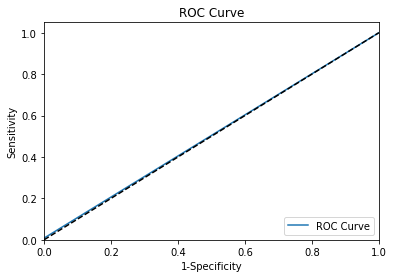

AUC: 0.5040871934604905
[[9633    0]
 [ 364    3]]


-Testing Metrics-


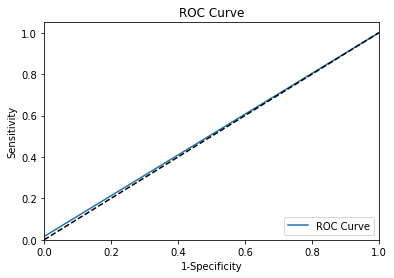

AUC: 0.5079575596816976
[[9623    0]
 [ 371    6]]


--Random Forrest Model--
-Training Metrics-


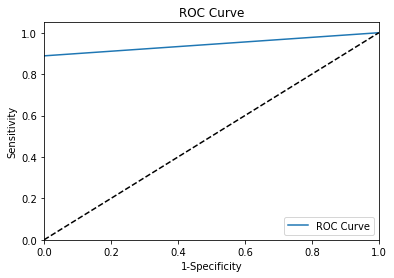

AUC: 0.944141689373297
[[9633    0]
 [  41  326]]


-Testing Metrics-


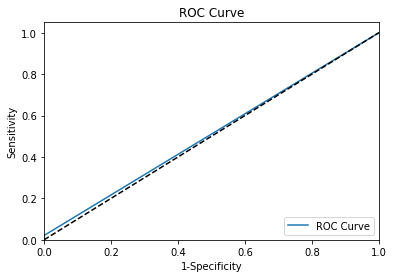

AUC: 0.510454203029821
[[9620    3]
 [ 369    8]]


--Neural Network Model--
-Training Metrics-


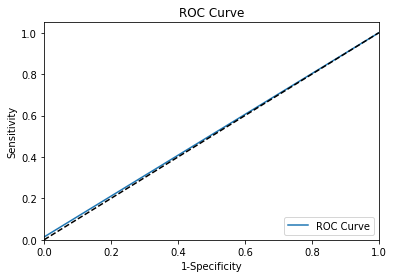

AUC: 0.5068119891008175
[[9633    0]
 [ 362    5]]


-Testing Metrics-


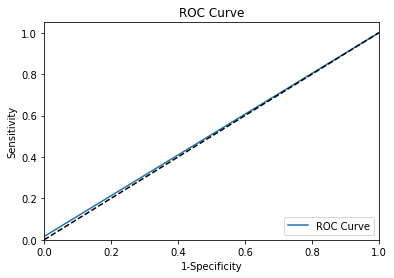

AUC: 0.5079575596816976
[[9623    0]
 [ 371    6]]


--------Metrics for Quarters Q12005 & Q22005 using Step Wise Forward Selection--------
--Logistic Regression Model--


NameError: name 'lm' is not defined

In [22]:
main()